In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

%matplotlib inline

## PCA

In [2]:
t0 = time.time()
df = pd.read_csv("./data/mRNA_cleaned_labeled_all.csv", index_col="sample_id")
print("loading matrix takes {0} seconds".format(time.time()-t0))

loading matrix takes 81.24846196174622 seconds


In [3]:
pca = PCA()
X = df[df.columns[3:]]
t0 = time.time()
pca.fit(X)
print("fitting PCA to this matrix takes {0} seconds".format(time.time()-t0))

fitting PCA to this matrix takes 801.0095572471619 seconds


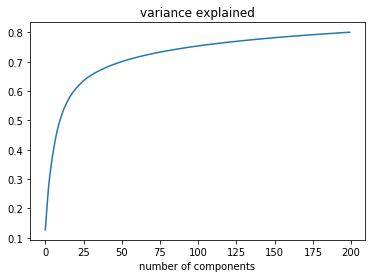

In [5]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:200])
plt.title("variance explained")
plt.xlabel("number of components")

In [27]:
# get number of components where 60%, 70%, 80% and 90% of of variations are preserved

def get_n_component_for_x_variance(x, variance_list):
    for i, variance in enumerate(variance_list):
        if variance > x:
            return i 
variance_preserved = np.cumsum(pca.explained_variance_ratio_)

for variance in [0.6,0.7,0.8,0.9, 0.99]:
    print(get_n_component_for_x_variance(variance, variance_preserved))

19
50
199
993
5001


In [28]:
X_tranformed = pca.transform(X)

In [50]:
for n in [20, 50, 200, 1000]:
    df_PCA = pd.DataFrame(X_tranformed[:, :n], index=df.index)
    label_columns = [i for i in df.columns if "label" in i]
    df_PCA[label_columns] = df[label_columns]
    df_PCA = df_PCA[label_columns + list(range(n))]
    df_PCA.to_csv("./data/mRNA_PCA_{0}_components.csv".format(n))